In [1]:
import os
import sys
import random

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from PIL import Image
from torchvision import models, transforms
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error

import tensorboard

sys.path.append('/home/jko/ice3d')
from models.mlp_regression import MLPRegression
from models.mlp_classification import MLPClassification
from models.resnet18_regression import ResNet18Regression
from models.resnet18_classification import ResNet18Classification

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from data.tabular_datamodule import TabularDataModule
from data.tabular_dataset import TabularDataset
from data.single_view_datamodule import SingleViewDataModule
from data.single_view_dataset import SingleViewDataset
from data.stereo_view_datamodule import StereoViewDataModule
from data.stereo_view_dataset import StereoViewDataset
import json
from torchvision.models import ResNet18_Weights


# Load data

In [59]:
# imagery
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
# tabular
tab_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
tab_file = 'ros-tabular-data-shuffled-default-subset-700000.parquet'
tab_path = os.path.join(tab_dir, tab_file)
tab_stereo_2ds_file = 'ros-tabular-data-stereo-default-2ds-shuffled-subset-700000.parquet'
tab_stereo_2ds_path = os.path.join(tab_dir, tab_stereo_2ds_file)
tab_stereo_phips_file = 'ros-tabular-data-stereo-default-phips-shuffled-subset-700000.parquet'
tab_stereo_phips_path = os.path.join(tab_dir, tab_stereo_phips_file)
# Load the class mapping from a JSON file
class_mapping_file = '/home/jko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

In [49]:
features = ['aspect_ratio_1', 'aspect_ratio_elip_1', 
'extreme_pts_1', 'contour_area_1', 'contour_perimeter_1', 
'area_ratio_1', 'complexity_1', 'circularity_1',
'aspect_ratio_2', 'aspect_ratio_elip_2', 'extreme_pts_2', 
'contour_area_2', 'contour_perimeter_2', 'area_ratio_2', 
'complexity_2', 'circularity_2']
# targets = ['rho_eff', 'sa_eff']
targets = ['n_arms']
batch_size = 128
n_rand = 666
num_workers = 16
def log_transform(x):
    return torch.log(x)
split = [0.7, 0.15, 0.15]
n_data = 700_000
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used
train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))

In [50]:
def get_transforms(data_type, input_channels, task_type):
    transforms = {}
    # Define transforms based on data_type
    if data_type in ['single_view_h5', 'stereo_view_h5']:
        train_transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        val_transform = T.Compose([
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        transforms['train'] = train_transform
        transforms['val'] = val_transform
        transforms['test'] = val_transform
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['train_target'] = target_transform
        transforms['val_target'] = target_transform
        transforms['test_target'] = target_transform    
        return transforms
    elif data_type == 'tabular':
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['target'] = target_transform
        return transforms
    else:
        return None
data_type = 'stereo_view_h5'
input_channels = 2
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)

In [51]:
# set up lightning data module (comment out as necessary)
# tabular
# dm = TabularDataModule(
#     data_file=tab_stereo_2ds_path,
#     feature_names=features,
#     target_names=targets,
#     batch_size=batch_size,
#     subset_size=1.0,
#     subset_seed=n_rand,
#     num_workers=num_workers,
#     task_type='regression',
#     class_to_idx=None,
#     target_transform=log_transform,
#     train_idx=train_idx,
#     val_idx=val_idx,
#     test_idx=test_idx,
# )
# # images (single view)
# dm = SingleViewDataModule(
#     hdf_file=data_path,
#     target_names=targets,
#     train_idx=train_idx,
#     val_idx=val_idx,
#     test_idx=test_idx,
#     batch_size=batch_size,
#     subset_size=None,
#     subset_seed=n_rand,
#     num_workers=16,
#     prefetch_factor=16,
#     train_transform=transforms['train'],
#     val_transform=transforms['val'],
#     test_transform=transforms['test'],
#     train_target_transform=transforms['train_target'],
#     val_target_transform=transforms['val_target'],
#     test_target_transform=transforms['test_target'],
#     task_type='regression',
#     class_to_idx=None
# )
# images (stereo)
dm = StereoViewDataModule(
    hdf_file_left=hdf_path1,
    hdf_file_right=hdf_path2,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='classification',
    class_to_idx=None
)
dm.setup()

# Load model

In [46]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-classification-stereo-2ds-subset-700k-csv/version_0/checkpoints/epoch=9-step=38280.ckpt'
model = ResNet18Classification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=2, 
    num_classes=7, 
    learning_rate=1e-3, 
    pretrained=False
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

ResNet18Classification(
  (resnet18): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Run inference

Regression

In [52]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
# n_batches=10
# Run inference on the test data and print progress
print_frq = 100
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        # if i >= n_batches:  # Stop after 20 batches
        #     break
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


Classification

In [56]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
pred_labels = np.argmax(all_preds, axis=1)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [57]:
print(all_preds.shape)
print(all_targets.shape)

(105001, 7)
(105001,)


# Calculate metrics

## Regression

In [35]:
print("rho_eff range:")
print(all_targets[:,0].min(), all_targets[:,0].max())
print("sa_eff range:")
print(all_targets[:,1].min(), all_targets[:,1].max())

rho_eff range:
0.008780266 0.2712172
sa_eff range:
0.11144753 0.9413749


In [36]:
# Compute RMSE
y_true = all_targets[:, 0]
y_pred = all_preds[:, 0]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE for rho_eff:", rmse)

y_true = all_targets[:, 1]
y_pred = all_preds[:, 1]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE for sa_eff:", rmse)

RMSE for rho_eff: 0.003291477554224572
RMSE for sa_eff: 0.012255245598017842


In [37]:
# Compute MAE
y_true = all_targets[:, 0]
y_pred = all_preds[:, 0]
mae = np.sqrt(mean_absolute_error(y_true, y_pred))
print("MAE for rho_eff:", mae)

y_true = all_targets[:, 1]
y_pred = all_preds[:, 1]
mae = np.sqrt(mean_absolute_error(y_true, y_pred))
print("MAE for sa_eff:", mae)

MAE for rho_eff: 0.04511408268785354
MAE for sa_eff: 0.09276890492660528


## Classification

In [ ]:
# precision

# recall

# f1-score

# balanced accuracy

# top-k accuracy

# Plots

Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


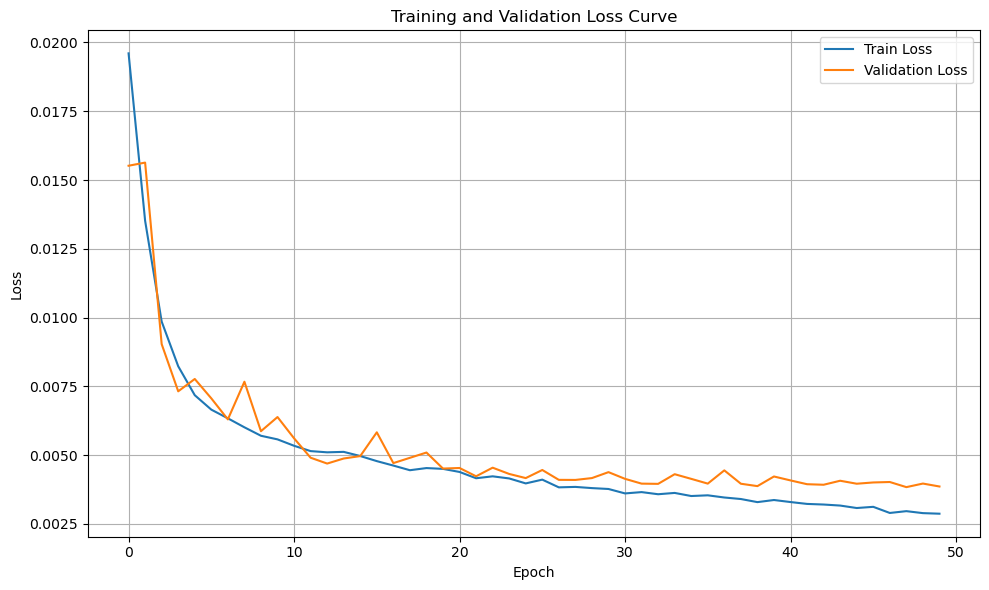

In [2]:
# plot loss curve
log_path = '/home/jko/ice3d/models/lightning_logs/resnet18-regression-subset-700k-csv/version_3/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
metrics_df.head()

,epoch,train_loss,val_loss
0,0,0.018601,0.015979
1,1,0.012936,0.033088
2,2,0.010228,0.007706
3,3,0.008313,0.011989
4,4,0.007594,0.006985


In [12]:
metrics_df.loc[metrics_df['val_loss']==metrics_df['val_loss'].min()]

,epoch,train_loss,val_loss
46,46,0.002988,0.00373


In [13]:
metrics_df.tail(10)

,epoch,train_loss,val_loss
40,40,0.003192,0.003841
41,41,0.003275,0.003822
42,42,0.003248,0.003831
43,43,0.003188,0.003771
44,44,0.003187,0.004577
45,45,0.003052,0.003890
46,46,0.002988,0.003730
47,47,0.003051,0.004044
48,48,0.002955,0.003737
49,49,0.002820,0.003763


R² for rho_eff: 0.99
R² for sa_eff: 0.99


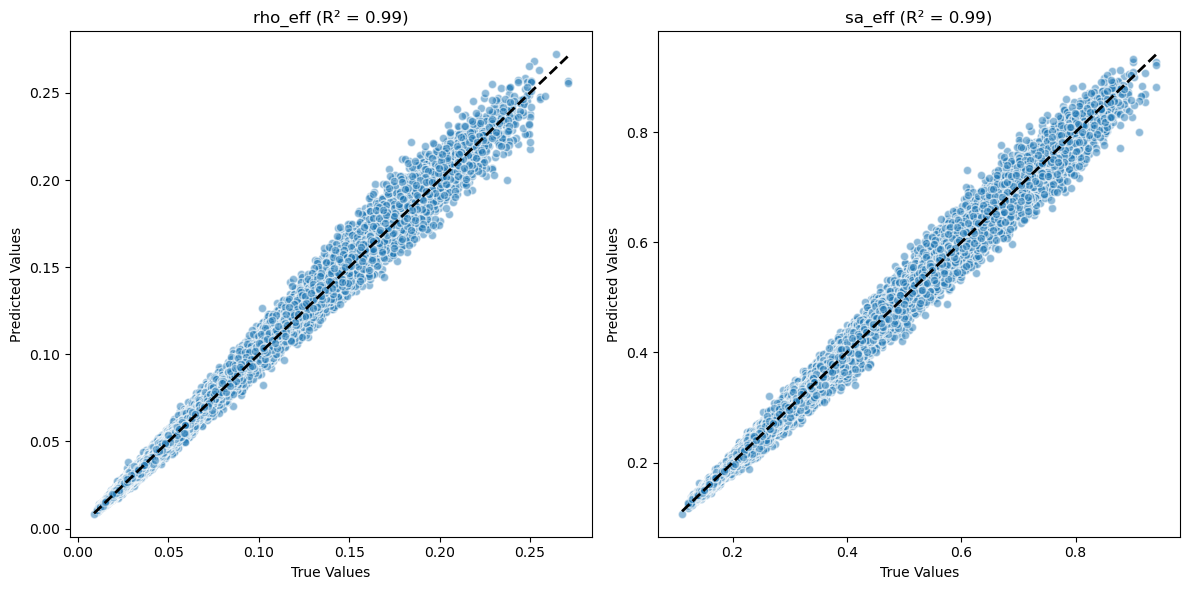

In [38]:
# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

Classification

Accuracy: 0.91


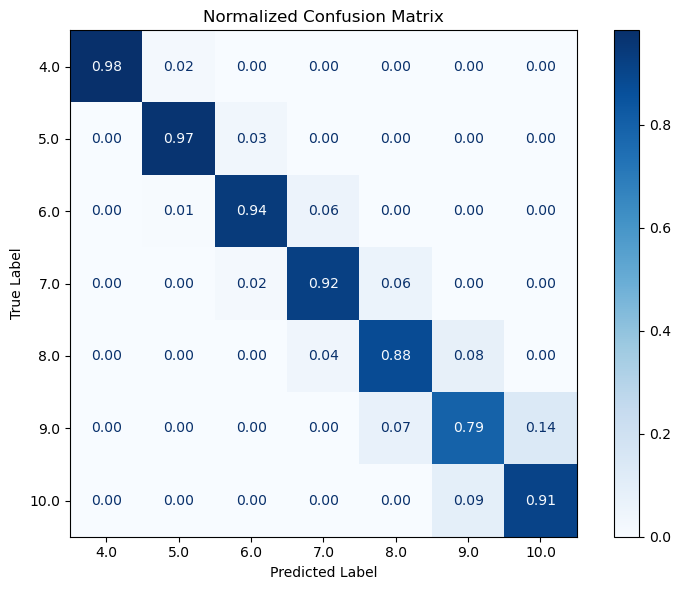

In [60]:
# Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_targets, pred_labels)
print(f'Accuracy: {accuracy:.2f}')

# Compute confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(all_targets, pred_labels, normalize='true')
class_labels = list(class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# MLP

## Classification

In [5]:
tabular_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2/ros-tabular-data.parquet'
feature_names = ['aspect_ratio','aspect_ratio_elip','extreme_pts','contour_area','contour_perimeter','area_ratio','complexity','circularity']
target_names = ['n_arms']
batch_size = 128
subset_size = 0.1  
seed = 666
num_workers = 18
task_type = 'classification'
# Load the class mapping from a JSON file
class_mapping_file = '/glade/u/home/joko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
def log_transform(x):
    return torch.log(x)

dm = TabularDataModule(
    data_file=tabular_file,
    feature_names=feature_names,
    target_names=target_names,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=seed,
    num_workers=num_workers,
    task_type=task_type,
    class_to_idx=class_to_idx,
    target_transform=log_transform,
    train_idx=None,
    val_idx=None,   
    test_idx=None
    )
dm.setup()


KeyboardInterrupt: 

Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


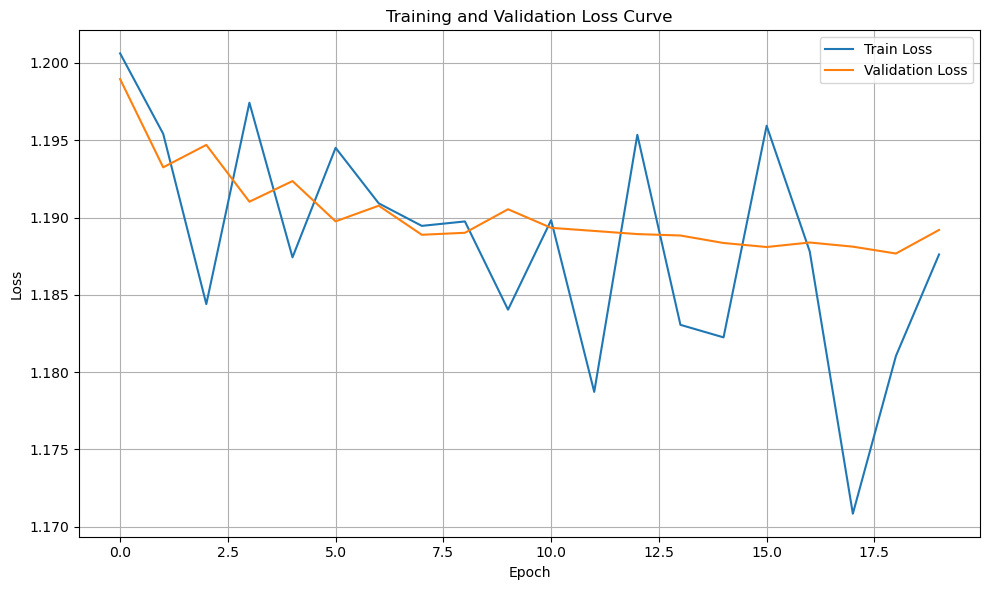

In [7]:
# plot loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/mlp-classification-subset-csv/version_10/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# load model and validate on val set
ckpt_path = '/glade/u/home/joko/ice3d/models/lightning_logs/mlp-classification-subset-csv/version_10/checkpoints/epoch=19-step=114860.ckpt'
model = MLPRegression.load_from_checkpoint(ckpt_path)
model.eval()
val_loader = dm.val_dataloader()
y_true = []
y_pred = []
for batch in val_loader:
    x, y = batch
    y_hat = model(x)
    y_true.append(y)
    y_pred.append(y_hat)
y_true = torch.cat(y_true).cpu().numpy()
y_pred = torch.cat(y_pred).cpu().numpy()
# use class mapping to get the class labels
y_true = [list(class_to_idx.keys())[list(class_to_idx.values()).index(int(y))] for y in y_true]
y_pred = [list(class_to_idx.keys())[list(class_to_idx.values()).index(int(y))] for y in y_pred]
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(class_to_idx.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# calculate accuracy
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Accuracy: {accuracy:.4f}')
# calculate f1-score    
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score: {f1:.4f}')